# PyTorch Workflow

Machine learning is all about finding patterns in data - and using those patterns to make predictions. Deep learning, with tools like neural networks, takes this idea further by tackling problems that are too complex for traditional algorithms.

Below you can find an example of PyTorch Workflow. We are going to cover all these points in the next part of the course.

![Example of encoding an RGB image](https://github.com/MatteoFalcioni/PyTorch_basics/blob/main/imgs/01_a_pytorch_workflow.png?raw=1)

We will be heavily using the [`torch.nn`](https://docs.pytorch.org/docs/stable/nn.html#module-torch.nn) module in this section.

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

## 1. Data (Preparing and Loading)

Machine learning is a game of two parts:

Turn your data, whatever it is, into numbers (a representation).
Pick or build a model to learn the representation as best as possible.
Sometimes one and two can be done at the same time.

But what if you don't have data?

Well, that's where we're at now.

No data.

But we can create some.

Let's create our data as a straight line.

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze needed later on
y = weight * X + bias

X[:10], y[:10], len(X), X.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 torch.Size([50, 1]))

Now we're going to move towards building a model that can learn the relationship between `X` (features) and `y` (labels).

### Split Data Into Training and Test

We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

| **Split**         | **Purpose**                                                            | **Proportion of Total Data** |
|-------------------|------------------------------------------------------------------------|-------------------------------|
| **Training set**   | Used to train the model by allowing it to learn underlying patterns.    | ~60–80%                       |
| **Validation set** | Used to fine-tune model parameters and monitor performance during development. | ~10–20%                       |
| **Testing set**    | Used to evaluate the model’s final performance on unseen data.         | ~10–20%                       |


For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` tensors

> **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn from training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [4]:
# Create train/test split

train_split = int( 0.8 * len(X) )

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Let's visualize our data to better grasp what we are doing:

In [5]:
def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize = (10,7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="y",  s=4, label="Test data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

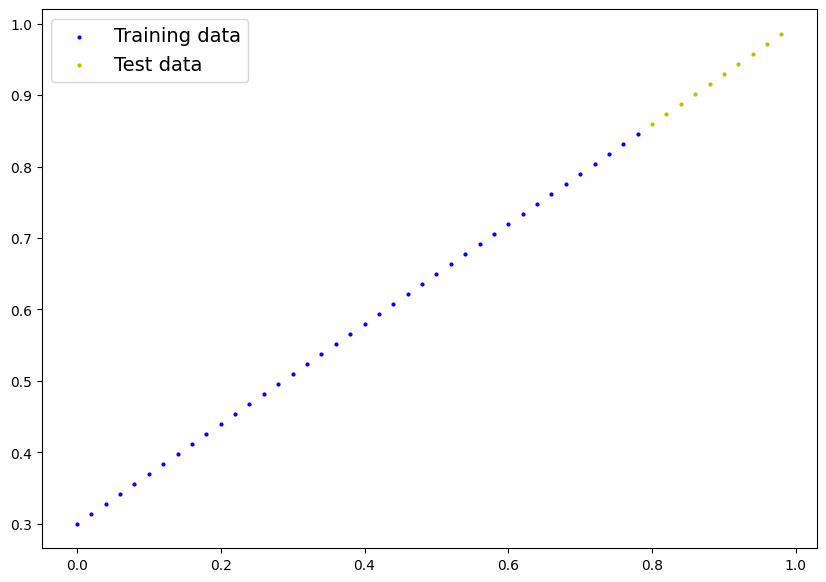

In [6]:
plot_predictions(X_train, y_train, X_test, y_test);

## 2. Build a Model

Let's now build our first PyTorch model. We want to build a linear regression model, i.e., a model that learns the equations $Y = a +bX$. How can we do this?

Let's write the class and then we'll comment every important step below.

In [19]:
# create linear regression model class

class LinearRegressionModel(nn.Module): # almost anything in Torch inherits from nn.Module

  def __init__(self):
    super().__init__()  # equivalent (but more stable) to nn.Module.__init__(self)

    # Initialize model parameters (could be more complex strctures - layers, functions ...)
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward method (mandatory)
  def forward(self, x: torch.Tensor) -> torch.Tensor: # expects a torch.Tensor and returns a torch.Tensor
    return self.weights * x + self.bias




First of all, we are inheriting from `torch.nn.Module`, which is must do practice when writing models in torch. This allows us to use all the structure from `nn.Module` in our custom Neural Network.

Then we are initializing the weight parameter as a [`Torch.nn.Parameter()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter), which is a special `Tensor` subclass. when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in `parameters()`. We set `requires_grad=True` even though it's default for `Parameter()`, just for clarity. This is `True` because we will need to compute gradients on our parameters in order to train the nn.

Finally, in the block:

```python
def forward(self, x: torch.Tensor) -> torch.Tensor: # expects a torch.Tensor and returns a torch.Tensor
return self.weights * x + self.bias
```

We defined our very important `forward()` method. Any subclass of `nn.Module()` must implement a `forward()` method.

The idea is the following:

* **1. forward():** our model will run the operation defined in `forward()` during training, starting with random `weights` and `biases`.

* **2. Validation:** At each iteration it will compute the error between its computation and the actual data it's trying to predict (the test data).

* **3. Optimization:** It will then optimize the values of the parameters `weights` and `biases` in order to reduce this error.

This last step - the optimization - is done through the so called **error backpropagation**.

Backpropagation is the adjusting of the model's weight based on the value of the error function - our **Loss** function.

This is done, mathematically, by computing the gradient of the Loss, and moving in parameters space in the (opposite) direction of the gradient, in order to minimize the Loss.

Find more about this topic - and all more "theoretical topics" in general - at **link da aggiungere alle altre note più serie, entropic theory of information**.



### Checking the Contents of Our PyTorch Model

How can we check what's going on inside a `LinearRegressionModel()` object? Let's investigate it:

In [23]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

model_0

LinearRegressionModel()

Of course printing out our model object doesn't give us a lot of information. But we can use the method `.parameters()` to chech the network parameters.

In [24]:
# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())  # list because it returns a generator

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using `.state_dict()`

In [25]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Because our model starts with random values, right now it'll have poor predictive power.

### Make predictions with our model

What is our predictive power right now that the model has just been initialized? Well, it will be very poor.

Let's run inference with our model real quick to check:

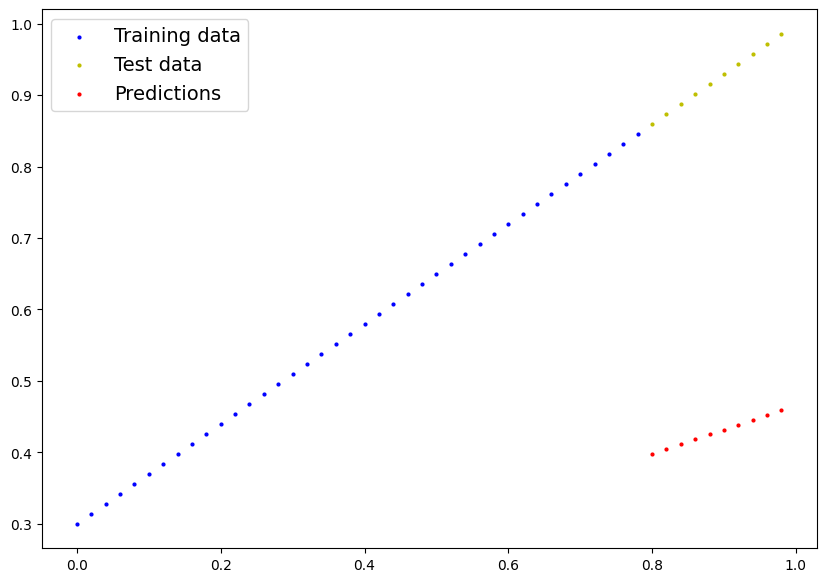

In [29]:
with torch.no_grad():   # context manager to disable gradients (very important!)
  y_pred = model_0(X_test)

plot_predictions(X_train, y_train, X_test, y_test, y_pred)

[`torch.no_grad()`](https://docs.pytorch.org/docs/stable/generated/torch.no_grad.html#no-grad) is a context manager that allows you to disable gradient computation when running inference or evaluation of your model, in order for your code to run a lot faster while computing predictions. Using it when running inference or evaluating the model on the test set should become an habit.

An alternative is [`torch.inference_mode()`](https://docs.pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html#inference-mode), which is actually preferred for pure inference, as it is even more optimized compared to `.no_grad()`. The main difference between the two is that you should use `torch.inference_mode()` only when running inference after training. If you need, in the same context or loop, to re-activate gradient computation (e.g. in the training + validation loop) use `torch.no_grad()`.



Now, we want to make to train our model in order to make it learn. Let's see how.

## Train the model

A question that might come natural at this time is: if we already know the parameters' correct values, why in the world should we construct a complex machinery like a Neural Network to approximate them? Well, the reason is that in many (actually, all) cases we don't know the values that we try to infer with models.

Imagine we are trying to make our model learn how to generate images of dogs. What are the correct values of the weights to produce such a seemingly impossible task? Well, we don't know of course: but our network can learn it. This is the incredible power of deep learning.  

Let's try and make our model learn. In order to do this, we should choose a **Loss** function: a criterion that tells us, looking at the predictions our model is making, how wrong it is. So that we can optimize the weights in order to reduce the Loss.

For this optimization we'll need an optimizer as well: something that computes the gradient $∇ \mathcal{L} $ of the loss and moves in the correct direction in order to minimize $\mathcal{L}$.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under `torch.nn.L1Loss()`) as our loss. The idea of MAE is depicted below.

In [31]:
![MAE loss](https://github.com/MatteoFalcioni/PyTorch_basics/blob/main/imgs/01-mae-loss-annotated.png?raw=1)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[MAE loss](https://github.com/MatteoFalcioni/PyTorch_basics/blob/main/imgs/01-mae-loss-annotated.png?raw=1)'


In [32]:
# Set the Loss
loss_fn = nn.L1Loss()

# Set the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

Our optimizer needs to now what are the parameters it should optimize, and the **learning rate** value. The latter is probably the most important *hyperparameter*. Its optimal value varies **a lot** for each task.

The learning rate is the 'size' of the step that our optimizer takes in the direction of $∇ \mathcal{L}$. So you can guess that its value changes completely the rate of convergence of our loss to its (local) minimum.

> **What are hyperparameters?**  Hyperparameters are parameters values *set by the user before training*. They are not learned from the data but rather control the learning process or model architecture. Different from the usual parameters, which we can define as the values that the model learns from data during training via backpropagation and gradient descent.

### Building a training (& testing) loop

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

We are talking about "loops" because we want our model to look (loop through) at each sample in each dataset.

We can summarize the main steps we need in a training loop as follows:
0. Loop through the data
1. Forward pass (get predictions from the model)
2. Compute the loss (to compare predictions and ground truth labels - how wrong are the predictions?)
3. Zero out the gradient with `.zero_grad()`
4. `loss.backward()` to run backpropagation (i.e., compute $\nabla \mathcal{L}$ by starting from the last layer of the network and going back to the first).
5. `optimizer.step()` - use the optimizer to adjust the weights (minimizing $\mathcal{L}$).

In [ ]:
# "epochs" = number of loops through the data (hyperparameter)
epochs = 1  # let's start with just 1

# 0. Loop through the data
for epoch in epochs:
  # Set the model to train mode
  model_0.train()

  # 1. Forward pass (get predictions from the model)
  y_pred = model_0.forward(X_train)

  # 2. Compute the loss
  Loss = loss_fn(y_pred)

  # 3. Zero out the gradient
  optimizer.zero_grad()

  # 4. Compute the gradients
  Loss.backward()

  # 5. Adjust the weights
  optimizer.step()